<a href="https://colab.research.google.com/github/llA-Wilsonll/Neural_Style_Transfer/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install package to allow me to google search for images:
* https://github.com/hardikvasa/google-images-download/blob/master/docs/examples.rst

In [0]:
pip install google_images_download

     |████████████████████████████████| 911kB 7.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/1f/28/ad/f56e7061e1d2a9a1affe2f9c649c2570cb9198dd24ede0bbab
Successfully built google-images-download


In [0]:
pip install pypng

     |████████████████████████████████| 296kB 5.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/a4/cd/54/c1d0803dfed5adf2bba530eda161581d9096d0154aee082cac
Successfully built pypng


In [0]:
import numpy as np
import png
import tensorflow as tf
from matplotlib.pyplot import imshow
from google_images_download import google_images_download   #importing the library
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import load_img

Using TensorFlow backend.


# Testing how Tensorflow optimises Variables

We are testing the case where we have a constant output ($Y=7$) and a costant function ($2\times X+1$) and seeing how tensorflow optimises the variable X:


*   Inputs: the 2 and the 1 in the function [ $2 \times X + 1$]?
*   Predicted value: $\hat{Y}=2\times X + 1$
*   Label (true value): $Y=7$, this is a placeholder
*   Weights: $X$ this is a variable.

We have a simple loss function:
$$\text{loss}=(Y - \hat{Y})^2$$

The goal is to update the variable $X$ such that our predicted value $\hat{Y}$ gets closer to the true value $Y=7$. This is done by optimising our loss function. 



In [0]:
# Placeholder for the true label
Y = tf.placeholder(tf.float32, [1], name='labels')

# Variable which will hold our "weights". Initialising it to 10.0
X = tf.Variable(10.0, name='weights')

# The predicted label, defined by some operation on the "weights" X
Y_hat = 2*X + 1

# The loss we will optimise, defined on the true and predicted labels
# and therefore defined as a function of the "weights" X
loss = tf.math.square(Y - Y_hat)

# Learning rate hyperparameter for gradient descent
learning_rate = 0.01
# Optimising the loss function using gradient descent
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# Required to initialise the tf variables
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    # ***initialization of all variables... NOTE this must be done before running any further sessions!***
    sess.run(init_op)
    
    for i in range(101):

      # This piece of code is what updates the weights variable X
      sess.run(train_step, feed_dict={Y: [7]})
      
      # Printing the value of X every 20 iterations
      if i%20 == 0:
        print('Iterartion ' + str(i) + ' X = ' + str(X.eval()))
        
    X_final = X
    print(X_final.eval())


Iterartion 0 X = 9.44
Iterartion 20 X = 4.215185
Iterartion 40 X = 3.2292976
Iterartion 60 X = 3.0432668
Iterartion 80 X = 3.008164
Iterartion 100 X = 3.0015404
3.0015404


As you can see, at each iteration Tensorflow optimises the loss function by updating the variables that are used in calculation which makes up the loss function, in this case $X$. \\

This example will be analogous to what we will do in Neural style transfer. 
*   Inputs: the content and style image pixel values?
*   Prediction: the activations of the generated image for certain layers. This will be some combination of operations on the weights (generated image in this case).
*   Labels: the activations of the content and style images for certain layers. We have a constant label we are trying to optimise towards. Make these placeholders?
*   Weights: the generated image pixel values. This will be a variable. 

The loss function is defined using the activations of the content, style and generated images. Thus, as long as we insure that **the loss function is defined as some operation on the generated image variable**, then as the only variable in the loss function is the generated image then each time we optimise the loss function this should be what is updated.

# Downloading the Content Images
* Downloading 10 images of "Australian Landmarks"
* Only choosing images with dimension 400*300
  * Reason being is that we don't want to have to distort the dimensions of the content image.
* Storing images in the directory content/images/content/

In [0]:
response = google_images_download.googleimagesdownload()   #class instantiation


arguments_content = {"keywords":"Australian Landmarks",
                     "limit":10,
                     "exact_size":"400,300",
                     "output_directory":"images",
                     "image_directory":"content",
                     "print_urls":True}   #creating list of arguments
paths_C = response.download(arguments_content)   #passing the arguments to the function
#print(paths)   #printing absolute paths of the downloaded images




Item no.: 1 --> Item name = Australian Landmarks
Evaluating...
Starting Download...
Image URL: https://cdn.hswstatic.com/gif/australia-pictures-1.jpg
Completed Image ====> 1.australia-pictures-1.jpg
Image URL: https://www.kidport.com/RefLib/WorldGeography/Australia/Images/Mountains.JPG
Completed Image ====> 2.Mountains.JPG
Image URL: https://www.gpsmycity.com/img/gd_attr/22407.jpg
Completed Image ====> 3.22407.jpg
Image URL: http://imagecache6.allposters.com/LRG/40/4000/9PHWF00Z.jpg
URLError on an image...trying next one... Error: HTTP Error 503: Service Unavailable
Image URL: https://i.pinimg.com/originals/ff/18/3f/ff183f8035812aad61829317ca79b6fb.jpg
Completed Image ====> 4.ff183f8035812aad61829317ca79b6fb.jpg
Image URL: http://imagecache6.allposters.com//LRG///27/2751/VQ3TD00Z.jpg
URLError on an image...trying next one... Error: HTTP Error 503: Service Unavailable
Image URL: https://static.businessinsider.com/image/51433d2d69beddbb34000001-400/image.jpg
Completed Image ====> 5.imag

# Downloading the Style Images
* Downloading 10 "impressionism" images (currently edited to download "Aboriginal Artwork" images)
* Only choosing images with dimension greater than 400*300
  * We can augment the images to have dimensions 400*300 and should still retain their "style"
* Storing images in the directory content/images/style/

In [0]:
arguments_style = {"keywords":"Aboriginal Artwork",
                   "limit":10,
                   "size":">400*300",
                   "output_directory":"images",
                   "image_directory":"style",
                   "print_urls":True}   #creating list of arguments
paths_S = response.download(arguments_style)   #passing the arguments to the functionw


Item no.: 1 --> Item name = Aboriginal Artwork
Evaluating...
Starting Download...
Image URL: https://img.theculturetrip.com/768x432/wp-content/uploads/2018/05/aboriginal-artwork--barbara-dieu-flickr-1.jpg
Completed Image ====> 1.aboriginal-artwork--barbara-dieu-flickr-1.jpg
Image URL: https://www.kateowengallery.com/image.axd?picture=2016%2F10%2FMEPU13351.png
Invalid or missing image format. Skipping...
Image URL: https://japingkaaboriginalart.com/wp-content/uploads/2-Joylene-011995.jpg
Completed Image ====> 2.2-Joylene-011995.jpg
Image URL: https://www.welcometocountry.org/wp-content/uploads/2017/08/tradara-briscoe-aboriginal-art.png
Completed Image ====> 3.tradara-briscoe-aboriginal-art.png
Image URL: https://japingkaaboriginalart.com/wp-content/uploads/bb-plugin/cache/Jap-012903-Walangkura-1024x675-landscape.jpg
Completed Image ====> 4.Jap-012903-Walangkura-1024x675-landscape.jpg
Image URL: https://d36lty2xa4smx3.cloudfront.net/product-images/b_92.jpg
Completed Image ====> 5.b_92.j

In [0]:
# Removing unwanted search results
'''
import shutil
shutil.rmtree('downloads/Polar bears')
shutil.rmtree('downloads/baloons')
'''

Next Steps

*   Make the search used for the content and style be user inputted
*   Resize the style image to be of the size of the content image they are being used with
*   For each content image, apply every style image
*   Iterate over all the content images
*   Use a pretained model such a VGG19 net
*   Define the content and style functions
*   This will require integrating with Tensorflow



https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

https://keras.io/applications/#vgg19

Loading the style images and reshaping them. \\
Then converting to an array

# Image Preprocessing

* Loading the style images and reshaping them.
* Then converting to an array
* Reshapping to have "samples" dimension
* Subtracting channel means


In [0]:
import glob
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import preprocess_input


def prepare_images(image_path,image_names):
  images_dict = {}
  
  for index, name in enumerate(image_names):
    # load the image
    image = load_img(image_path + name, target_size=(300, 400))

    # convert pixels into numpy array
    image = img_to_array(image)

    # Add "samples" dimension to array, as this is what the network is expecting as input
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # VGG input images need to have the same mean RGB values subtracted as was used for imagenet: RGB [123.68, 116.779, 103.939]
    image = preprocess_input(image)

    # Store preprocessed images into a dictionary
    images_dict["image{0}".format(index)] = image
  
  return images_dict

In [0]:
# Preprocess Style Images
style_image_path = "/content/images/style/"
style_image_names = glob.glob1(style_image_path,"*.jpg")

style_images_dict = prepare_images(style_image_path,style_image_names)

In [0]:
style_images_dict["image0"].shape

(1, 300, 400, 3)

In [0]:
# Preprocess Content Images
content_image_path = "/content/images/content/"
content_image_names = glob.glob1(content_image_path,"*.jpg")

content_images_dict = prepare_images(content_image_path,content_image_names)

In [0]:
print(style_images_dict['image0'].shape)
print(content_images_dict['image0'].shape)

(1, 300, 400, 3)
(1, 300, 400, 3)


We will set up our post processing function so that once the generated images is "generated", we can apply the necessary post processing and save it.

This function can be called every dozen or so iterations to see how the image generation is progressing

In [0]:
def output_and_save_image(image, save_path, save_name):
  # This is for BGR channels
  image = image.reshape(300,400,3) + np.array([103.939, 116.779,123.68]).reshape((1,1,3))
  
  # Limiting the min value to 0 and max value to 255 (maybe need to call image[0])
  image = np.clip(image, 0, 255).astype('uint8')
  
  # Saving the image to the provided path. Have to reorder channels to from RGB to BGR
  image = image[...,::-1]
  png.from_array(image,"RGB").save(save_path + save_name + ".png")

In [0]:
# TESTING output_and_save_image()
output_and_save_image(style_images_dict['image2'],"/content/images/","saved_image")

# How to create the Generated Image


1.   Subtract the mean RGB value from when VGG19 was trained on image net (use preprocess_input) from the input images
2.   Calculate the Style Cost and Content Cost, and then combine to form J
      * Assume inputs to cost functions are pre-calculated activations
3.   Optimize J
4.   After optimizing, reshape the output generated image (andd back the mean RGB values)


# Create Iteration 0 Generated Image

Initialize generated image to be a nosiy imagewhich is created from the content image.

In [0]:
def generate_noise_image(content_image, noise_ratio = 0.6):
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, 300, 400, 3)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

In [0]:
def generate_noise_image_dict(images_dict,image_names):
  generated_images_dict = {}
  
  # Iterate over content images
  for index, name in enumerate(image_names):
    generated_images_dict["image{0}".format(index)] = generate_noise_image(images_dict["image{0}".format(index)])
    
  return generated_images_dict

Generate inital image "generated" image for each content image

In [0]:
generated_images_dict = generate_noise_image_dict(content_images_dict,content_image_names)

In [0]:
print(content_images_dict.keys())
print(generated_images_dict.keys())

dict_keys(['image0', 'image1', 'image2', 'image3', 'image4', 'image5', 'image6', 'image7', 'image8'])
dict_keys(['image0', 'image1', 'image2', 'image3', 'image4', 'image5', 'image6', 'image7', 'image8'])


Test that it worked for the images

W0714 03:52:03.077208 140554220246912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


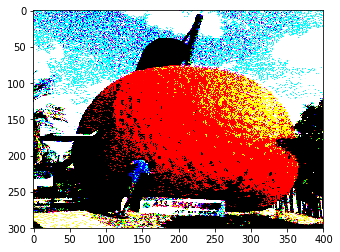

In [0]:
# Reording Channels to RGB so that they are in the correct order for imshow
generated_image_test = generated_images_dict['image6'][...,::-1]
imshow(generated_image_test[0])

W0714 03:52:06.372630 140554220246912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


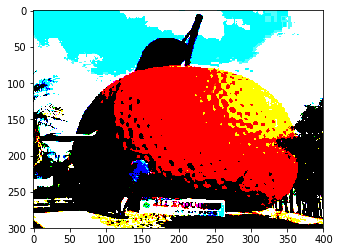

In [0]:
content_image_test = content_images_dict['image6'][...,::-1]
imshow(content_image_test[0])

W0714 03:52:07.999889 140554220246912 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


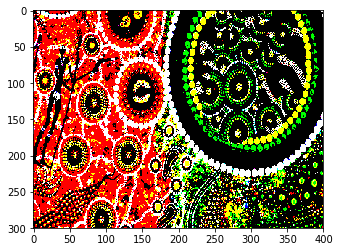

In [0]:
style_image_test = style_images_dict['image3'][...,::-1]
imshow(style_image_test[0])

# VGG19
* include_Top=False - don't include the 3 fully-connected layers at the end of the network
* input_shape=(400,300,3) - input image shape
* weights='imagenet' - get pre-trained weights trained on ImageNet

https://www.tensorflow.org/beta/tutorials/generative/style_transfer

Code to that loads the model and grabs the weights

In [0]:
'''
VGG19_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(400,300,3))

print()
for layer in VGG19_model.layers:
  print(layer.name)
  weights = layer.get_weights() # list of numpy arrays
  print(weights)

#VGG19_model(tf.convert_to_tensor(style_images_dict['image0']))
print(VGG19_model.input)
print(VGG19_model.get_layer('block2_conv1').output)
'''


## Code to Get Layer Activations

The following function builds a VGG19 model that returns a list of intermediate layer outputs:
https://www.tensorflow.org/beta/tutorials/generative/style_transfer

We will later define a model with the below definition in the same session we call these functions

In [0]:
"""
# Load our model. Load pretrained VGG, trained on imagenet data
VGG19_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet',input_shape=(300,400,3))
VGG19_model.trainable = False
"""

In [0]:
def define_model(content_layers, style_layers):
  """ 
  Creates a vgg model that returns a list of intermediate output values.
  
  Arguments:
      - content_layers: python list of layers you want to use when calculating
                        the content cost. 
                        e.g.LAYERS = ['block1_conv1', 'block2_conv1'] 
                        
      - style_layers: python list of layers you want to use when calculating
                      the style cost.                  
  """
  
  # Required layers to calculate style and content cost functions.
  # Use union to take care of cases where content_layers and style_layers are
  # referencing some of the same layers.
  #required_layers = list(set().union(content_layers,style_layers))
  #required_layers.sort()
  
  # Loading the VGG19 model pretrained on imagenet data
  VGG19_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet',input_shape=(300,400,3))
  VGG19_model.trainable = False
  
  content_outputs = [VGG19_model.get_layer(name).output for name in content_layers]
  style_outputs = [VGG19_model.get_layer(name).output for name in style_layers]
  
  model_outputs = content_outputs + style_outputs

  model = tf.keras.Model(VGG19_model.input, model_outputs)
  return model

Remeber to run things in a seesion. Initially i had a problem which WAS THE STYLE_EXTRACTOR AND STYLE_OUTPUTS WEREN'T IN THE SESSION:
https://github.com/tensorflow/tensorflow/issues/28287

Feeding an image into the VGG19 model and getting the activations for the provided layer_names

In [0]:
def get_activations(model, image, content_layers, style_layers):
  """
  Arguments:
      - model: the model which is defined by the define_model function
  
      - image:  tensor of the image you want to feed into the model. 
                has shape (1,300,400,3)
                
      - content_layers: python list of layers you want to use when calculating
                        the content cost. 
                        e.g.LAYERS = ['block1_conv1', 'block2_conv1'] 
                        
      - style_layers: python list of layers you want to use when calculating
                      the style cost. 
  """
  
  model_outputs = model(image)
  content_activations = [layer[0] for layer in model_outputs[:len(content_layers)]]
  style_activations = [layer[0] for layer in model_outputs[len(content_layers):]]
  return content_activations, style_activations

Storing a Tensor of activations for given layers into a python dictionary. \\
May no longer need below code.

In [0]:
def get_activations_dictionary(layer_names, activations):
  """
  Arguments:       
      - layer_names: python list of layers you want to get activations for.
                     e.g.LAYERS = ['block1_conv1', 'block2_conv1'] 
                     
      - activations: Tensor of activations for the provided layer_names
      
  Returns:
      - activations_tensor_dict: dictionary of tensors for the given layers
      - activations_array_dict: dictionary of arrays for the given layers
  """
  
  activations_tensor_dict = {}
#   activations_array_dict = {}
  
  if len(layer_names) == 1:
#     print(layer_names[0])
#     print(activations[0].eval().shape)
    activations_tensor_dict[layer_names[0]] = activations[0]
#     activations_array_dict[layer_names[0]] = activations[0].eval()
  else:
    for name, output in zip(layer_names, activations):
#       print(name)
#       print(output.eval().shape)
      activations_tensor_dict[name] = output
#       activations_array_dict[name] = output.eval()
  
  return activations_tensor_dict #, activations_array_dict

Defining the layers we want to use to measure the style:

In [0]:
STYLE_LAYERS = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

Defining the layers we want to use to measure the content:

In [0]:
CONTENT_LAYERS = ['block5_conv2']

Combining to get the layers required from the generated image

In [0]:
GENERATED_LAYERS = list(set().union(STYLE_LAYERS,CONTENT_LAYERS))
GENERATED_LAYERS.sort()
print(GENERATED_LAYERS)

['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1', 'block5_conv2']


TEST: Feeding the style and content images to the VGG19 model and getting the activations for the required layers and storing into a python dictionary.

In [0]:
tf.reset_default_graph()
sess = tf.Session()
with sess.as_default():
  # Load our model. Load pretrained VGG, trained on imagenet data
  VGG19_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet',input_shape=(300,400,3))
  VGG19_model.trainable = False
  
  style_model_outputs = get_activations(style_images_dict['image0'],VGG19_model,STYLE_LAYERS)
  print(style_model_outputs[0].get_shape())
  style_activations_tensor_dict, style_activations_array_dict = get_activations_dictionary(STYLE_LAYERS,style_model_outputs)
  print(style_activations_tensor_dict['block4_conv1'])
  print(style_activations_array_dict['block4_conv1'])

  content_model_outputs = get_activations(content_images_dict['image0'],VGG19_model,CONTENT_LAYERS)
  content_activations_tensor_dict, content_activations_array_dict = get_activations_dictionary(CONTENT_LAYERS,content_model_outputs)

Feed Content Image and its Layers to vgg_layers to get the output

1. Next steps is to figure out how to feed in the style and content images to get their activations. Save them as tensorflow constants
2. Then create the cost function to minimize
    * How does it know to optimize generated image and not content or style?

Still need to find a way to iterate the generated image and update it each time.
1. Initially need to convert_to_tensor
2. Calculate activations for style and content layers
3. Then make a variable

4. Also maybe make content and style activations constants


# Define Content Cost Function

Future edit: I may want to define the *content* cost function so that it can be done over multiple layers as will be done for the style cost function

In [0]:
def content_cost(content_activations,generated_activations):
  """
  Arguments:
      - content_activations:  activations of the content image calculated 
                              for specific layers
      - generated_activations:  activations of the generated image calculated 
                                for the same specific layers                              
  """
  
  n_H, n_W, n_C = generated_activations.get_shape().as_list()

  # Reshape content and generated activations
  #content_activations_unrolled = tf.reshape(content_activations,[m,n_H*n_W,n_C])
  #generated_activations_unrolled = tf.reshape(generated_activations,[m,n_H*n_W,n_C])

  # Compute the content cost
  J_content = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(content_activations,generated_activations)))

  return J_content

TEST: 6.76559

In [0]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

ValueError: ignored

# Define Style Cost Function

Define the Gram matrix so we can compare the correlation between filters

In [0]:
def gram_matrix(input_matrix):
  """
  Arguments:
      - input_matrix:  tensor with 2 dimensions (a matrix)                             
  """ 
  
  gram_matrix = tf.matmul(input_matrix,tf.transpose(input_matrix))
  
  return gram_matrix

Define the style cost for a given layer

In [0]:
def style_layer_cost(style_activations,generated_activations):
  """
  Arguments:
      - style_activations:  a tensor of activations of the style image for a 
                            given layer
      - generated_activations:  a tensor of activations of the generated image 
                                for a the same given layer
  """ 
  # Get the height, width and number of channels 
  height, width, channels = generated_activations.get_shape().as_list()

  # Reshape the images to have them of shape (channels, height*width)
  style_activations = tf.transpose(tf.reshape(style_activations,[height*width,channels]))
  generated_activations = tf.transpose(tf.reshape(generated_activations,[height*width,channels]))

  # Computing gram_matrices for both the style and generated images
  gram_style = gram_matrix(style_activations)
  gram_generated = gram_matrix(generated_activations)

  J_style_layer = (1/((2*channels*height*width)**2))*tf.reduce_sum(tf.square(tf.subtract(gram_style,gram_generated)))

  return J_style_layer

Note: the content tensors need to be defined in the same session as when I am calling them, rather then calculating them in a earlier session. 

In [0]:
tf.reset_default_graph()
sess = tf.Session()
with sess.as_default():
  
  # Load our model. Load pretrained VGG, trained on imagenet data
  VGG19_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet',input_shape=(300,400,3))
  VGG19_model.trainable = False
  
  style_model_outputs = get_activations(style_images_dict['image0'],VGG19_model,STYLE_LAYERS)
  style_activations_tensor_dict, style_activations_array_dict = get_activations_dictionary(STYLE_LAYERS,style_model_outputs)


  content_model_outputs = get_activations(content_images_dict['image0'],VGG19_model,CONTENT_LAYERS)
  content_activations_tensor_dict, content_activations_array_dict = get_activations_dictionary(CONTENT_LAYERS,content_model_outputs)

  #TESTING it works given two input tensors of the same shape
  x = style_layer_cost(style_activations_tensor_dict['block5_conv1'],content_activations_tensor_dict['block5_conv2']).eval()
  print(x)

TEST: 9.19028

In [0]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = style_layer_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190278


Need to define the style cost which sums the style_layer_cost

In [0]:
def style_cost(style_activations,generated_activations,layer_names):#,model,session,):
  """
  Arguments:
      - style_activations_dict: a dictionary of activations for the style image 
                                in the form of tensors for given layers 
      - generated_activations_dict: a dictionary of activations for the 
                                    generated image in the form of tensors 
                                    for the same given layers 
      - layer_names: the layers which we will use to define the style
  """ 
  # initialise style cost
  J_style = 0
  
  # coefficient to scale between layers. Ideally we would have this as an input
  coeff = 1 / len(layer_names)
  
  #for layer_name in layer_names: 
  for name, a_C, a_G in zip(layer_names, style_activations, generated_activations):
    J_style_layer = style_layer_cost(a_C, a_G)
    J_style += coeff * J_style_layer
    
  return J_style

In [0]:
style_cost(style_activations_tensor_dict,generated_s_activations_tensor_dict,STYLE_LAYERS)

NameError: ignored

### NOTE
I need to test this works with an input other then the style dictionary twice. Specifcially, I should test on the initial generated image.

In [0]:
tf.reset_default_graph()
sess = tf.Session()
with sess.as_default():
  
  # Load our model. Load pretrained VGG, trained on imagenet data
  VGG19_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet',input_shape=(300,400,3))
  VGG19_model.trainable = False
  
  style_model_outputs = get_activations(style_images_dict['image0'],VGG19_model,STYLE_LAYERS)
  style_activations_tensor_dict, style_activations_array_dict = get_activations_dictionary(STYLE_LAYERS,style_model_outputs)


  content_model_outputs = get_activations(content_images_dict['image0'],VGG19_model,CONTENT_LAYERS)
  content_activations_tensor_dict, content_activations_array_dict = get_activations_dictionary(CONTENT_LAYERS,content_model_outputs)

  #TESTING it works given two input tensors of the same shape
  x = style_cost(style_activations_tensor_dict,style_activations_tensor_dict,STYLE_LAYERS).eval()
  print(x)

W0708 22:12:24.843280 139670068701056 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


80142336/80134624 [==============================] - 2s 0us/step


TypeError: ignored

# Total Cost Function
The total cost function is just a linear combination of the content and style cost functions. \\
Need to give alpha and beta initial values so that the function can be run without needing to specify them

In [0]:
def total_cost(J_content, J_style, alpha = 10, beta = 0.4):
  """
  Arguments:
      - J_content: the content cost 
      - J_style: the style cost
      - alpha: value with which to scale the content cost
      - beta: value with which to scale the style cost
  """  
  
  J_total = alpha * J_content + beta * J_style
  
  return J_total

Testing the **total_cost** function works:

Attemp 1 at trying to build an algorithm to train the model. \\
Think i need to have a consistent model defined throughout the process. That is, maybe make the model an input to all the functions and define it at the start of the below session and make sure it is passed through the whole way. 

In [0]:
sess.run(tf.report_uninitialized_variables())

W0713 00:51:17.488659 139693714438016 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


RuntimeError: ignored

Testing how sessions and graphs work

In [0]:
import tensorflow as tf

graph1 = tf.Graph()
graph2 = tf.Graph()

with graph1.as_default() as graph:
  a = tf.constant(0, name='a')
  graph1_init_op = tf.global_variables_initializer()

with graph2.as_default() as graph:
  a = tf.constant(1, name='a')
  graph2_init_op = tf.global_variables_initializer()

sess1 = tf.Session(graph=graph1)
sess2 = tf.Session(graph=graph2)
sess1.run(graph1_init_op)
sess2.run(graph2_init_op)

# Both tensor names are a!
print(sess1.run(graph1.get_tensor_by_name('a:0'))) # prints 0
print(sess2.run(graph2.get_tensor_by_name('a:0'))) # prints 1

0
1


In [0]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
with sess.as_default():
  
  # Load our model which uses the pretrained VGG19, trained on imagenet data
  # and only outputs the activations for the provided content and style layers
  model = define_model(CONTENT_LAYERS, STYLE_LAYERS)
  model.layers[0].trainable = True
#   input_1.trainable = True
  print(model.summary())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 400, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 100, 128)      0     

In [0]:
print(image.get_shape().as_list())
print(style_image.get_shape().as_list())
print(content_image.get_shape().as_list())

NameError: ignored

In [0]:
# Testing adding channel values
az = tf.constant([[[[103.939, 116.779,123.68]]]])
print(az.get_shape().as_list())

wilson = tf.constant([[[[1.0,2.0,3.0],[10.0,10.0,10.0]]]])
print(wilson.get_shape().as_list())

full = az + wilson

full_clipped = tf.clip_by_value(full, clip_value_min=105.0, clip_value_max=120.0)

init_op = tf.global_variables_initializer()

with tf.Session() as sess1:
    # ***initialization of all variables... NOTE this must be done before running any further sessions!***
    sess1.run(init_op)
    sess1.run(full_clipped)
    print(full.get_shape().as_list())
    print(full.eval())
    print(full_clipped.get_shape().as_list())
    print(full_clipped.eval())

[1, 1, 1, 3]
[1, 1, 2, 3]
[1, 1, 2, 3]
[[[[104.939 118.779 126.68 ]
   [113.939 126.779 133.68 ]]]]
[1, 1, 2, 3]
[[[[105.    118.779 120.   ]
   [113.939 120.    120.   ]]]]


maybe I need to normalise the activations so the cost doesnt blow up

In [0]:
# Reset the graph
tf.reset_default_graph()

with tf.Session() as sess:
  
  writer = tf.summary.FileWriter("./logs",sess.graph)

  # Create initial generated image  
  image = tf.get_variable("image",initializer=tf.convert_to_tensor(generated_images_dict['image6'], dtype=tf.float32))
  
  def clip_0_255(image):
    image = image + tf.constant([[[[103.939, 116.779,123.68]]]])
    image =  tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0)
    image = image.eval()
    return preprocess_input(image)

  # Load our model which uses the pretrained VGG19, trained on imagenet data
  # and only outputs the activations for the provided content and style layers
  model = define_model(CONTENT_LAYERS, STYLE_LAYERS)

  # Activations from style image required to calculate Style Cost
  style_image = tf.convert_to_tensor(style_images_dict['image3'])
  style_c_outputs, style_s_outputs = get_activations(model, style_image, CONTENT_LAYERS, STYLE_LAYERS)
  sess.run(style_s_outputs)
  style_activations_tensor_dict = get_activations_dictionary(STYLE_LAYERS, style_s_outputs)

  # Activations from content image required to calculate Content Cost
  content_image = tf.convert_to_tensor(content_images_dict['image6'])
  content_c_outputs, content_s_outputs = get_activations(model, content_image, CONTENT_LAYERS, STYLE_LAYERS)
  sess.run(content_c_outputs)
  content_activations_tensor_dict = get_activations_dictionary(CONTENT_LAYERS,content_c_outputs)

  # Feed image variable to the model so we can get the activations
  model_outputs = model(image)

  # Splitting the outputs into content and style outputs
  generated_c_outputs = [layer[0] for layer in model_outputs[:len(CONTENT_LAYERS)]]
  generated_s_outputs = [layer[0] for layer in model_outputs[len(CONTENT_LAYERS):]]
  generated_c_activations_tensor_dict = get_activations_dictionary(CONTENT_LAYERS,generated_c_outputs)
  generated_s_activations_tensor_dict = get_activations_dictionary(STYLE_LAYERS,generated_s_outputs)

  # Calculating the loss function
  J_content = content_cost(content_activations_tensor_dict['block5_conv2'],generated_c_activations_tensor_dict['block5_conv2'])
  J_style = style_cost(style_s_outputs,generated_s_outputs,STYLE_LAYERS)
  J_total = total_cost(J_content, J_style)

  # Define the optimiser
  optimizer = tf.train.AdamOptimizer(learning_rate=0.2, beta1=0.99, beta2=0.999, epsilon=1e-1)

  # Specifying to apply the optimiser to minise the loss J_total
  train_step = optimizer.minimize(J_total)

  # Required to initialise the tf variables
  init_op = tf.global_variables_initializer()

  # ***initialization of all variables... NOTE this must be done before running any further sessions!***
  sess.run(init_op)
  
  sess.run(model(image))

#   start = image.eval()

  for i in range(2):

    # This piece of code is what updates the weights variable X
    sess.run(train_step)
    Jt, Jc, Js = sess.run([J_total, J_content, J_style])
    print("Iteration " + str(i) + " :")
    print("total cost = " + str(Jt))
    print("content cost = " + str(Jc))
    print("style cost = " + str(Js))
    
#     if i == 0:
#       iteration1 = image.eval()
#     elif i == 1:
#       iteration2 = image.eval()
#     else:
#       iteration3 = image.eval() 
      
    sess.run(image.assign(clip_0_255(image)))
    sess.run(model(image))
    print(image.get_shape().as_list())
    # Printing the value of X every 20 iterations
#       if i%20 == 0:
#         print('Iterartion ' + str(i) + ' X = ' + str(X.eval()))

  gen = image
  print(gen.eval())
  
  writer.close()

  

Iteration 0 :
total cost = 1131704.5
content cost = 0.055600613
style cost = 2829260.0
[1, 300, 400, 3]
Iteration 1 :
total cost = 167589.4
content cost = 3.177605e-05
style cost = 418973.5
[1, 300, 400, 3]
[[[[ 35.43084     14.829964    -5.7512054 ]
   [ 37.00103     -2.2469406   -8.97123   ]
   [ 23.099426    -1.7417297    1.1214142 ]
   ...
   [ 25.80909      9.650764    -1.1985397 ]
   [ 28.892525    14.38282     -6.4171906 ]
   [ 28.084068     7.463333    11.933388  ]]

  [[ 22.88073      0.6802521  -11.746323  ]
   [ 22.12999     14.206245    -7.5690536 ]
   [ 37.897453    15.09771     -1.5683365 ]
   ...
   [ 38.5299       6.6999435   11.901024  ]
   [ 35.96807     11.3057785    8.889885  ]
   [ 25.136116    25.395653     5.85717   ]]

  [[ 41.346138    13.265266     8.874184  ]
   [ 30.709496    17.471138     7.0252457 ]
   [ 18.995438     3.7276764  -15.06266   ]
   ...
   [ 23.63855      9.92852      9.896263  ]
   [ 29.448586    19.894798    13.843025  ]
   [ 21.551048     5

In [0]:
!pip install -q tf-nightly-2.0-preview
# Load the TensorBoard notebook extension
%load_ext tensorboard

     |████████████████████████████████| 79.1MB 320kB/s 
     |████████████████████████████████| 3.9MB 44.8MB/s 
     |████████████████████████████████| 61kB 19.6MB/s 
     |████████████████████████████████| 460kB 38.2MB/s 


In [0]:
%tensorboard --logdir logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 1419.

W0714 05:10:08.834048 140554220246912 manager.py:321] invalid info file: '/tmp/.tensorboard-info/pid-1369.info'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/manager.py", line 316, in get_all
    info = _info_from_string(contents)
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/manager.py", line 155, in _info_from_string
    raise ValueError("incompatible version: %r" % (json_value,))
ValueError: incompatible version: {'cache_key': 'eyJhcmd1bWVudHMiOlsiLS1sb2dkaXIiLCJsb2dzIl0sImNvbmZpZ3VyZV9rd2FyZ3MiOnt9LCJ3b3JraW5nX2RpcmVjdG9yeSI6Ii9jb250ZW50In0=', 'db': '', 'logdir': 'logs', 'path_prefix': '', 'pid': 1369, 'port': 6006, 'start_time': 1563080809, 'version': '1.15.0a20190713'}
W0714 05:10:09.398949 140554220246912 manager.py:321] invalid info file: '/tmp/.tensorboard-info/pid-1369.info'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/manager.py", line 316, in get_all
    info = _inf

In [0]:

  for i in range(20):
    
    # Activations from generated image required for both the content and style costs 
#     model_outputs = model(image)
#     print("can i make it")
#     generated_c_outputs = [layer[0] for layer in model_outputs[:len(CONTENT_LAYERS)]]
#     generated_s_outputs = [layer[0] for layer in model_outputs[len(CONTENT_LAYERS):]]
#     print("this far") 
    
#     generated_c_activations_tensor_dict = {}
#     generated_s_activations_array_dict = {}

#     if len(CONTENT_LAYERS) == 1:
#       print(CONTENT_LAYERS[0])
#      # print(activations[0].eval().shape)
#       generated_c_activations_tensor_dict[CONTENT_LAYERS[0]] = generated_c_outputs[0]
#       print("ok ok ok")
#       generated_s_activations_array_dict[CONTENT_LAYERS[0]] = generated_c_outputs[0].eval()
#       print("for reals")
#     else:
#       for name, output in zip(CONTENT_LAYERS, generated_c_outputs):
#         print(name)
#      #   print(output.eval().shape)
#         generated_c_activations_tensor_dict[name] = output
#         generated_s_activations_array_dict[name] = output.eval()
  
#     generated_c_activations_tensor_dict, generated_c_activations_array_dict = get_activations_dictionary(CONTENT_LAYERS,generated_c_outputs)
#     generated_s_activations_tensor_dict, generated_s_activations_array_dict = get_activations_dictionary(STYLE_LAYERS,generated_s_outputs)
#     print("mADE IT")
    
    optimizer = tf.train.AdamOptimizer(2.0)
    if i == 0:
      generated = image
    print("n1")
    model_outputs = model(generated)
    
    generated_c_outputs = [layer[0] for layer in model_outputs[:len(CONTENT_LAYERS)]]
    generated_s_outputs = [layer[0] for layer in model_outputs[len(CONTENT_LAYERS):]]
    generated_c_activations_tensor_dict, generated_c_activations_array_dict = get_activations_dictionary(CONTENT_LAYERS,generated_c_outputs)
    generated_s_activations_tensor_dict, generated_s_activations_array_dict = get_activations_dictionary(STYLE_LAYERS,generated_s_outputs)


    J_content = content_cost(content_activations_tensor_dict['block5_conv2'],generated_c_activations_tensor_dict['block5_conv2'])
    J_style = style_cost(style_activations_tensor_dict,generated_s_activations_tensor_dict,STYLE_LAYERS)
    J_total = total_cost(J_content, J_style)
    
    train_step = optimizer.minimize(J_total)
    
    gen = model.input
    print(gen)
    if i == 0:
      generated =  sess.run(gen, feed_dict={"input_1:0": image.eval()})
    else:
      print("n2")
      generated =  sess.run(gen, feed_dict={"input_1:0": generated})
#     with tf.GradientTape() as tape:
#       model_outputs = model(image)
#       generated_c_outputs = [layer[0] for layer in model_outputs[:len(CONTENT_LAYERS)]]
#       generated_s_outputs = [layer[0] for layer in model_outputs[len(CONTENT_LAYERS):]]
#       generated_c_activations_tensor_dict, generated_c_activations_array_dict = get_activations_dictionary(CONTENT_LAYERS,generated_c_outputs)
#       generated_s_activations_tensor_dict, generated_s_activations_array_dict = get_activations_dictionary(STYLE_LAYERS,generated_s_outputs)

      
#       J_content = content_cost(content_activations_tensor_dict['block5_conv2'],generated_c_activations_tensor_dict['block5_conv2'])
#       J_style = style_cost(style_activations_tensor_dict,generated_s_activations_tensor_dict,STYLE_LAYERS)
#       J_total = total_cost(J_content, J_style)

#     grad = tape.gradient(J_total, image)
#     print(J_total.eval())
#     print(image)
#     print(grad)
#     optimizer.apply_gradients([(grad, image)])
#     image.assign(clip_0_1(image))

    # Compute the generated image by running the session on the current model['input']
  #  generated_image = VGG19_model.input
  #  print(generated_image)


#     # Print every 20 iteration.
#     if i%20 == 0:
#         Jt, Jc, Js = sess.run([J, J_content, J_style])
#         print("Iteration " + str(i) + " :")
#         print("total cost = " + str(Jt))
#         print("content cost = " + str(Jc))
#         print("style cost = " + str(Js))

#         # save current generated image in the "/output" directory
#         save_image("output/" + str(i) + ".png", generated_image)

  # save last generated image
#   generated =  sess.run(gen, feed_dict={"input_1:0": image.eval()})
  print(generated)
  output_and_save_image(generated, "/content/","gen_image_2")
#   save_image('output/generated_image_2.jpg', generated_image)

In [0]:
# Reset the graph
tf.reset_default_graph()

# Start an interactive session
sess = tf.InteractiveSession()
with sess.as_default():
  
  # Load our model which uses the pretrained VGG19, trained on imagenet data
  # and only outputs the activations for the provided content and style layers
  model = define_model(CONTENT_LAYERS, STYLE_LAYERS)
  
  # Activations from style image required to calculate Style Cost
  style_c_outputs, style_s_outputs = get_activations(model, style_images_dict['image3'], CONTENT_LAYERS, STYLE_LAYERS)
  style_activations_tensor_dict, style_activations_array_dict = get_activations_dictionary(STYLE_LAYERS, style_s_outputs)
  
  # Activations from content image required to calculate Content Cost
  content_c_outputs, content_s_outputs = get_activations(model, content_images_dict['image6'], CONTENT_LAYERS, STYLE_LAYERS)
  content_activations_tensor_dict, content_activations_array_dict = get_activations_dictionary(CONTENT_LAYERS,content_c_outputs)
  
  # Create initial generated image  
  image = tf.get_variable("image",initializer=tf.convert_to_tensor(generated_images_dict['image6'], dtype=tf.float32))
  image = image.initialized_value()
  
  for i in range(20):
    
    # Activations from generated image required for both the content and style costs 
#     model_outputs = model(image)
#     print("can i make it")
#     generated_c_outputs = [layer[0] for layer in model_outputs[:len(CONTENT_LAYERS)]]
#     generated_s_outputs = [layer[0] for layer in model_outputs[len(CONTENT_LAYERS):]]
#     print("this far") 
    
#     generated_c_activations_tensor_dict = {}
#     generated_s_activations_array_dict = {}

#     if len(CONTENT_LAYERS) == 1:
#       print(CONTENT_LAYERS[0])
#      # print(activations[0].eval().shape)
#       generated_c_activations_tensor_dict[CONTENT_LAYERS[0]] = generated_c_outputs[0]
#       print("ok ok ok")
#       generated_s_activations_array_dict[CONTENT_LAYERS[0]] = generated_c_outputs[0].eval()
#       print("for reals")
#     else:
#       for name, output in zip(CONTENT_LAYERS, generated_c_outputs):
#         print(name)
#      #   print(output.eval().shape)
#         generated_c_activations_tensor_dict[name] = output
#         generated_s_activations_array_dict[name] = output.eval()
  
#     generated_c_activations_tensor_dict, generated_c_activations_array_dict = get_activations_dictionary(CONTENT_LAYERS,generated_c_outputs)
#     generated_s_activations_tensor_dict, generated_s_activations_array_dict = get_activations_dictionary(STYLE_LAYERS,generated_s_outputs)
#     print("mADE IT")
    
    optimizer = tf.train.AdamOptimizer(2.0)
    if i == 0:
      generated = image
    print("n1")
    model_outputs = model(generated)
    
    generated_c_outputs = [layer[0] for layer in model_outputs[:len(CONTENT_LAYERS)]]
    generated_s_outputs = [layer[0] for layer in model_outputs[len(CONTENT_LAYERS):]]
    generated_c_activations_tensor_dict, generated_c_activations_array_dict = get_activations_dictionary(CONTENT_LAYERS,generated_c_outputs)
    generated_s_activations_tensor_dict, generated_s_activations_array_dict = get_activations_dictionary(STYLE_LAYERS,generated_s_outputs)


    J_content = content_cost(content_activations_tensor_dict['block5_conv2'],generated_c_activations_tensor_dict['block5_conv2'])
    J_style = style_cost(style_activations_tensor_dict,generated_s_activations_tensor_dict,STYLE_LAYERS)
    J_total = total_cost(J_content, J_style)
    
    train_step = optimizer.minimize(J_total)
    
    gen = model.input
    print(gen)
    if i == 0:
      generated =  sess.run(gen, feed_dict={"input_1:0": image.eval()})
    else:
      print("n2")
      generated =  sess.run(gen, feed_dict={"input_1:0": generated})
#     with tf.GradientTape() as tape:
#       model_outputs = model(image)
#       generated_c_outputs = [layer[0] for layer in model_outputs[:len(CONTENT_LAYERS)]]
#       generated_s_outputs = [layer[0] for layer in model_outputs[len(CONTENT_LAYERS):]]
#       generated_c_activations_tensor_dict, generated_c_activations_array_dict = get_activations_dictionary(CONTENT_LAYERS,generated_c_outputs)
#       generated_s_activations_tensor_dict, generated_s_activations_array_dict = get_activations_dictionary(STYLE_LAYERS,generated_s_outputs)

      
#       J_content = content_cost(content_activations_tensor_dict['block5_conv2'],generated_c_activations_tensor_dict['block5_conv2'])
#       J_style = style_cost(style_activations_tensor_dict,generated_s_activations_tensor_dict,STYLE_LAYERS)
#       J_total = total_cost(J_content, J_style)

#     grad = tape.gradient(J_total, image)
#     print(J_total.eval())
#     print(image)
#     print(grad)
#     optimizer.apply_gradients([(grad, image)])
#     image.assign(clip_0_1(image))

    # Compute the generated image by running the session on the current model['input']
  #  generated_image = VGG19_model.input
  #  print(generated_image)


#     # Print every 20 iteration.
#     if i%20 == 0:
#         Jt, Jc, Js = sess.run([J, J_content, J_style])
#         print("Iteration " + str(i) + " :")
#         print("total cost = " + str(Jt))
#         print("content cost = " + str(Jc))
#         print("style cost = " + str(Js))

#         # save current generated image in the "/output" directory
#         save_image("output/" + str(i) + ".png", generated_image)

  # save last generated image
#   generated =  sess.run(gen, feed_dict={"input_1:0": image.eval()})
  print(generated)
  output_and_save_image(generated, "/content/","gen_image_2")
#   save_image('output/generated_image_2.jpg', generated_image)

n1
Tensor("input_1:0", shape=(?, 300, 400, 3), dtype=float32)
n1
Tensor("input_1:0", shape=(?, 300, 400, 3), dtype=float32)
n2
n1
Tensor("input_1:0", shape=(?, 300, 400, 3), dtype=float32)
n2
n1
Tensor("input_1:0", shape=(?, 300, 400, 3), dtype=float32)
n2
n1
Tensor("input_1:0", shape=(?, 300, 400, 3), dtype=float32)
n2
n1
Tensor("input_1:0", shape=(?, 300, 400, 3), dtype=float32)
n2
n1
Tensor("input_1:0", shape=(?, 300, 400, 3), dtype=float32)
n2
n1
Tensor("input_1:0", shape=(?, 300, 400, 3), dtype=float32)
n2
n1
Tensor("input_1:0", shape=(?, 300, 400, 3), dtype=float32)
n2
n1
Tensor("input_1:0", shape=(?, 300, 400, 3), dtype=float32)
n2
n1
Tensor("input_1:0", shape=(?, 300, 400, 3), dtype=float32)
n2
n1
Tensor("input_1:0", shape=(?, 300, 400, 3), dtype=float32)
n2
n1
Tensor("input_1:0", shape=(?, 300, 400, 3), dtype=float32)
n2
n1
Tensor("input_1:0", shape=(?, 300, 400, 3), dtype=float32)
n2
n1
Tensor("input_1:0", shape=(?, 300, 400, 3), dtype=float32)
n2
n1
Tensor("input_1:0", shape

In [0]:
dict_test={'block1_conv1':5,
            'block2_conv1':6,
            'block3_conv1':7, 
            'block4_conv1':899, 
            'block5_conv1':-22,
           'block5_conv2':778       
}
dict_test2 = {k: dict_test[k] for k in STYLE_LAYERS}

GENERATED_LAYERS = list(set().union(STYLE_LAYERS,CONTENT_LAYERS))
GENERATED_LAYERS.sort()

print(Total_Layers)

['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1', 'block5_conv2']


In [0]:
generated_layers = STYLE_LAYERS + CONTENT_LAYERS
print(generated_layers)

['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1', 'block5_conv2']


To DO:
1. Get content and style activations by running the content and style images through the model (google)
2. Iterate pver number of iterations for genreated image, with each iteration running the generated image through the model and changing the generated image

# Create Graph to Optimize the Cost Function

Maybe use the following to help define the loss functions with tensorflow. At least I can use these to understand how tensorflow works and then do it myself:
* Siraj's tutorial: https://github.com/llSourcell/How_to_do_style_transfer_in_tensorflow/blob/master/Style_Transfer.ipynb
* The VGG16.py folder he imports which gives him a lot of useful functions and the VGG16 class: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/vgg16.py


In [0]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(VGG19_model, to_file='vgg.png')

NameError: ignored

In [0]:
VGG19_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(400,300,3))
print(VGG19_model.summary())

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 400, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 75, 128)      0     